In [1]:
# Load the packages
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
import sys
import csv
import math
import keras
import argparse
import scipy.io
import sklearn
import sklearn.datasets
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/affine/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.regularizers import L1L2
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD

In [3]:
#Load dataset
master_data= pd.read_csv('/home/affine/Downloads/Deep_Learning/demo/demo/TGS/tgs-data-science-master-c3f8b3a2900f40ddde655f8ef5f17d00cfaa7033/data/Master_dataset_v1.csv')

/home/affine/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,20,23,25,34,48,65,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Columns in dataset
master_data.columns

Index(['Unnamed: 0', 'WellId', 'LeaseId', 'GroupId', 'API', 'FieldName_x',
       'Well Name and Number', 'WellNumber_x', 'OperatorName_x', 'StateName_x',
       'County_x', 'ProductionMonthYear', 'DaysOnProduction', 'Gas', 'Oil',
       'Water', 'ProductionType', 'ProductionTypeName', 'WellsReported',
       'AllocationMethod', 'DisplayFormation_x', 'StateLeaseId', 'WellName',
       'WellNumber_y', 'BasinName', 'DisplayFormation_y', 'Township',
       'TownshipDirection', 'Range', 'RangeDirection', 'Section', 'District',
       'Abstract', 'Survey', 'Block', 'Offshore', 'Area', 'OffshoreBlock',
       'QuarterQuarter', 'FootageNS', 'DirectionNS', 'FootageEW',
       'DirectionEW', 'SurfaceLatitude', 'SurfaceLongitude', 'BottomLatitude',
       'BottomLongitude', 'SpudDate', 'PlugDate', 'CompletionDate',
       'FirstProductionDate', 'FirstMonth', 'HasProduction', 'WellType',
       'TotalVerticalDepth', 'MeasuredDepth', 'ElevationGround',
       'ElevationKellyBushing', 'ElevationWat

In [5]:
#selecting Operator 'Occidental W TX OVERTHRUST INC.'
master_data1=master_data[master_data.OperatorName_x=="OCCIDENTAL W TX OVERTHRUST INC."]
#master_data1.head()

In [6]:
#select required API
master_data1=master_data1[master_data1.API==42371381340000]#42371381180000]#42371383480000]#42371381890000]#42371378930000]
labels=['Gas','ProductionMonthYear1','YearMonth']
master_data1=master_data1[labels]

#Sort data based on YearMonth
master_data1=master_data1.sort_values(by=['YearMonth'])#, ascending=[1, 1],axis=1)
#master_data1.tail()

In [7]:
master_data2=master_data1
master_data2=pd.DataFrame(master_data2)
# master_data2['start_date']=datetime.strptime(master_data1['ProductionMonthYear1'].iloc[0], "%Y-%m-%d")
# print(type(pd.DataFrame(master_data2['start_date']).iloc[0,0]))
# print(type(pd.DataFrame(master_data2['ProductionMonthYear1']).iloc[0,0]))

In [8]:
# master_data2['ProductionMonthYear1']=master_data2['ProductionMonthYear1'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# master_data2['days_age']=master_data2['ProductionMonthYear1'].sub(master_data2['start_date'])
# master_data2['days_age']=master_data2['days_age']/np.timedelta64(1,'D')

In [9]:
#Set YearMonth as Index for production
master_data2=master_data2[['YearMonth','Gas']]#,'days_age']]
master_data2=master_data2.iloc[:-1,:]# removing 201708 & 201709 values as they were zeros
master_data2.set_index('YearMonth')

,Gas
YearMonth,
200805,670.0
200806,156299.0
200807,188835.0
200808,178813.0
200809,162469.0
200810,159712.0
200811,179992.0
200812,189537.0
200901,175661.0


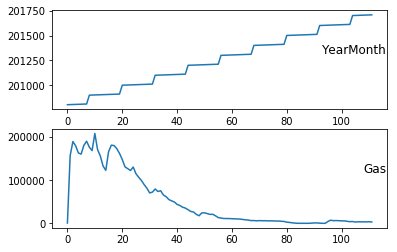

In [10]:
from matplotlib import pyplot
# load dataset
dataset = master_data2
values = dataset.values

# specify columns to plot
groups = [0,1]#,2]#3,4]#,5,6,7,8,9,10]
i = 0
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i+1)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
#Define lag(time steps for training) and n_seq(number of time steps to be predicted in future)
n_seq = 12
n_feature=1
n_lag= 12


In [13]:
# load dataset
dataset = master_data2.iloc[:,1:]
values = dataset.values
print(values.shape)
# ensure all data is float
values = values.astype('float32')
#print(values)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_seq)

# drop columns we don't want to predict
# reframed.drop(reframed.iloc[:,25:], axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

(112, 1)
(112, 1)
    var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  \
12    0.003229    0.753353    0.910175   0.861870   0.783093   0.769804   
13    0.753353    0.910175    0.861870   0.783093   0.769804   0.867553   
14    0.910175    0.861870    0.783093   0.769804   0.867553   0.913559   
15    0.861870    0.783093    0.769804   0.867553   0.913559   0.846677   
16    0.783093    0.769804    0.867553   0.913559   0.846677   0.809458   

    var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)     ...      var1(t+2)  \
12   0.867553   0.913559   0.846677   0.809458     ...       0.589403   
13   0.913559   0.846677   0.809458   1.000000     ...       0.796131   
14   0.846677   0.809458   1.000000   0.819382     ...       0.869196   
15   0.809458   1.000000   0.819382   0.748905     ...       0.865576   
16   1.000000   0.819382   0.748905   0.637554     ...       0.831509   

    var1(t+3)  var1(t+4)  var1(t+5)  var1(t+6)  var1(t+7)  var1(t+8)  \
12   0.796131   0.86

In [14]:
# split into train and test sets
values = reframed.values
train = values[:-1, :]
test = values[-1:, :]

# split into input and outputs
train_X, train_y = train[:, :-(n_seq)], train[:, -(n_seq):]
test_X, test_y = test[:, :-n_seq], test[:, -n_seq:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_feature))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(88, 12, 1) (88, 12) (1, 12, 1) (1, 12)


In [15]:
#Hyperparameters
h1=n_lag*2
h2=n_lag*2
h3=n_seq
h4=n_seq
drop1=0.3
drop2=0.2
drop3=0.1 
drop4=0.1
n_y=n_seq
epoch=1000
batch_size=8
lr=0.0009
L1=0.00
L2=0.01

In [16]:
# model.add(LSTM(h1, batch_input_shape=(batch_size,train_X.shape[1],train_X.shape[2]), stateful=True))#,return_sequences=True, recurrent_regularizer=reg))

In [17]:
# design network
model = Sequential()
reg = L1L2(l1=L1, l2=L2)
model.add(LSTM(h1, input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True, recurrent_regularizer=reg))
model.add(Dropout(drop1, seed = 1))
model.add(LSTM(h2,return_sequences=True))
model.add(Dropout(drop2, seed = 1))
model.add(LSTM(h3,return_sequences=True))
model.add(Dropout(drop3, seed = 1))
model.add(LSTM(h4,return_sequences=False))
model.add(Dropout(drop4, seed = 1))
model.add(Dense(n_seq, activation='relu'))
model.add(Dense(n_y, activation='relu'))
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer= adam)

In [88]:
# model=load_model('LSTM_12_month.h5')
# weights=model.get_weights()
# print(weights)
# model.save_weights('weights.hdf5')
# model.set_weights(weights)
# model.load_weights('weights.hdf5')
# model.load_weights('weights_42371382790000.hdf5')

Train on 88 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3873 - val_loss: 0.2301
Epoch 2/1000
 - 0s - loss: 0.3607 - val_loss: 0.2175
Epoch 3/1000
 - 0s - loss: 0.3383 - val_loss: 0.2019
Epoch 4/1000
 - 0s - loss: 0.3177 - val_loss: 0.1839
Epoch 5/1000
 - 0s - loss: 0.2981 - val_loss: 0.1661
Epoch 6/1000
 - 0s - loss: 0.2803 - val_loss: 0.1509
Epoch 7/1000
 - 0s - loss: 0.2615 - val_loss: 0.1364
Epoch 8/1000
 - 0s - loss: 0.2438 - val_loss: 0.1220
Epoch 9/1000
 - 0s - loss: 0.2258 - val_loss: 0.1129
Epoch 10/1000
 - 0s - loss: 0.2082 - val_loss: 0.1034
Epoch 11/1000
 - 0s - loss: 0.1973 - val_loss: 0.0957
Epoch 12/1000
 - 0s - loss: 0.1862 - val_loss: 0.0875
Epoch 13/1000
 - 0s - loss: 0.1744 - val_loss: 0.0796
Epoch 14/1000
 - 0s - loss: 0.1659 - val_loss: 0.0731
Epoch 15/1000
 - 0s - loss: 0.1545 - val_loss: 0.0677
Epoch 16/1000
 - 0s - loss: 0.1487 - val_loss: 0.0621
Epoch 17/1000
 - 0s - loss: 0.1420 - val_loss: 0.0572
Epoch 18/1000
 - 0s - loss: 0.1364 - val_loss: 0

 - 0s - loss: 0.0343 - val_loss: 0.0032
Epoch 152/1000
 - 0s - loss: 0.0313 - val_loss: 0.0026
Epoch 153/1000
 - 0s - loss: 0.0301 - val_loss: 0.0023
Epoch 154/1000
 - 0s - loss: 0.0323 - val_loss: 0.0026
Epoch 155/1000
 - 0s - loss: 0.0384 - val_loss: 0.0031
Epoch 156/1000
 - 0s - loss: 0.0369 - val_loss: 0.0030
Epoch 157/1000
 - 0s - loss: 0.0339 - val_loss: 0.0030
Epoch 158/1000
 - 0s - loss: 0.0341 - val_loss: 0.0033
Epoch 159/1000
 - 0s - loss: 0.0356 - val_loss: 0.0027
Epoch 160/1000
 - 0s - loss: 0.0319 - val_loss: 0.0029
Epoch 161/1000
 - 0s - loss: 0.0295 - val_loss: 0.0026
Epoch 162/1000
 - 0s - loss: 0.0343 - val_loss: 0.0024
Epoch 163/1000
 - 0s - loss: 0.0346 - val_loss: 0.0025
Epoch 164/1000
 - 0s - loss: 0.0353 - val_loss: 0.0027
Epoch 165/1000
 - 0s - loss: 0.0365 - val_loss: 0.0031
Epoch 166/1000
 - 0s - loss: 0.0354 - val_loss: 0.0030
Epoch 167/1000
 - 0s - loss: 0.0334 - val_loss: 0.0026
Epoch 168/1000
 - 0s - loss: 0.0323 - val_loss: 0.0025
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.0308 - val_loss: 0.0033
Epoch 301/1000
 - 0s - loss: 0.0291 - val_loss: 0.0031
Epoch 302/1000
 - 0s - loss: 0.0290 - val_loss: 0.0026
Epoch 303/1000
 - 0s - loss: 0.0409 - val_loss: 0.0025
Epoch 304/1000
 - 0s - loss: 0.0317 - val_loss: 0.0025
Epoch 305/1000
 - 0s - loss: 0.0325 - val_loss: 0.0025
Epoch 306/1000
 - 0s - loss: 0.0334 - val_loss: 0.0029
Epoch 307/1000
 - 0s - loss: 0.0316 - val_loss: 0.0031
Epoch 308/1000
 - 0s - loss: 0.0265 - val_loss: 0.0030
Epoch 309/1000
 - 0s - loss: 0.0299 - val_loss: 0.0031
Epoch 310/1000
 - 0s - loss: 0.0289 - val_loss: 0.0033
Epoch 311/1000
 - 0s - loss: 0.0308 - val_loss: 0.0032
Epoch 312/1000
 - 0s - loss: 0.0285 - val_loss: 0.0028
Epoch 313/1000
 - 0s - loss: 0.0270 - val_loss: 0.0027
Epoch 314/1000
 - 0s - loss: 0.0299 - val_loss: 0.0028
Epoch 315/1000
 - 0s - loss: 0.0320 - val_loss: 0.0031
Epoch 316/1000
 - 0s - loss: 0.0331 - val_loss: 0.0031
Epoch 317/1000
 - 0s - loss: 0.0284 - val_loss: 0.0032
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.0273 - val_loss: 0.0033
Epoch 450/1000
 - 0s - loss: 0.0281 - val_loss: 0.0038
Epoch 451/1000
 - 0s - loss: 0.0267 - val_loss: 0.0033
Epoch 452/1000
 - 0s - loss: 0.0326 - val_loss: 0.0026
Epoch 453/1000
 - 0s - loss: 0.0297 - val_loss: 0.0026
Epoch 454/1000
 - 0s - loss: 0.0290 - val_loss: 0.0034
Epoch 455/1000
 - 0s - loss: 0.0342 - val_loss: 0.0035
Epoch 456/1000
 - 0s - loss: 0.0268 - val_loss: 0.0034
Epoch 457/1000
 - 0s - loss: 0.0269 - val_loss: 0.0030
Epoch 458/1000
 - 0s - loss: 0.0265 - val_loss: 0.0030
Epoch 459/1000
 - 0s - loss: 0.0271 - val_loss: 0.0029
Epoch 460/1000
 - 0s - loss: 0.0288 - val_loss: 0.0031
Epoch 461/1000
 - 0s - loss: 0.0284 - val_loss: 0.0027
Epoch 462/1000
 - 0s - loss: 0.0411 - val_loss: 0.0032
Epoch 463/1000
 - 0s - loss: 0.0311 - val_loss: 0.0043
Epoch 464/1000
 - 0s - loss: 0.0339 - val_loss: 0.0038
Epoch 465/1000
 - 0s - loss: 0.0214 - val_loss: 0.0028
Epoch 466/1000
 - 0s - loss: 0.0267 - val_loss: 0.0029
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.0235 - val_loss: 0.0035
Epoch 599/1000
 - 0s - loss: 0.0288 - val_loss: 0.0032
Epoch 600/1000
 - 0s - loss: 0.0323 - val_loss: 0.0037
Epoch 601/1000
 - 0s - loss: 0.0244 - val_loss: 0.0035
Epoch 602/1000
 - 0s - loss: 0.0261 - val_loss: 0.0028
Epoch 603/1000
 - 0s - loss: 0.0324 - val_loss: 0.0032
Epoch 604/1000
 - 0s - loss: 0.0289 - val_loss: 0.0048
Epoch 605/1000
 - 0s - loss: 0.0364 - val_loss: 0.0042
Epoch 606/1000
 - 0s - loss: 0.0307 - val_loss: 0.0035
Epoch 607/1000
 - 0s - loss: 0.0254 - val_loss: 0.0032
Epoch 608/1000
 - 0s - loss: 0.0275 - val_loss: 0.0033
Epoch 609/1000
 - 0s - loss: 0.0296 - val_loss: 0.0037
Epoch 610/1000
 - 0s - loss: 0.0276 - val_loss: 0.0038
Epoch 611/1000
 - 0s - loss: 0.0280 - val_loss: 0.0036
Epoch 612/1000
 - 0s - loss: 0.0281 - val_loss: 0.0033
Epoch 613/1000
 - 0s - loss: 0.0264 - val_loss: 0.0032
Epoch 614/1000
 - 0s - loss: 0.0256 - val_loss: 0.0034
Epoch 615/1000
 - 0s - loss: 0.0245 - val_loss: 0.0034
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.0246 - val_loss: 0.0030
Epoch 748/1000
 - 0s - loss: 0.0277 - val_loss: 0.0032
Epoch 749/1000
 - 0s - loss: 0.0260 - val_loss: 0.0033
Epoch 750/1000
 - 0s - loss: 0.0409 - val_loss: 0.0028
Epoch 751/1000
 - 0s - loss: 0.0387 - val_loss: 0.0031
Epoch 752/1000
 - 0s - loss: 0.0360 - val_loss: 0.0045
Epoch 753/1000
 - 0s - loss: 0.0284 - val_loss: 0.0058
Epoch 754/1000
 - 0s - loss: 0.0281 - val_loss: 0.0054
Epoch 755/1000
 - 0s - loss: 0.0300 - val_loss: 0.0035
Epoch 756/1000
 - 0s - loss: 0.0283 - val_loss: 0.0034
Epoch 757/1000
 - 0s - loss: 0.0282 - val_loss: 0.0040
Epoch 758/1000
 - 0s - loss: 0.0242 - val_loss: 0.0042
Epoch 759/1000
 - 0s - loss: 0.0267 - val_loss: 0.0038
Epoch 760/1000
 - 0s - loss: 0.0254 - val_loss: 0.0036
Epoch 761/1000
 - 0s - loss: 0.0258 - val_loss: 0.0032
Epoch 762/1000
 - 0s - loss: 0.0262 - val_loss: 0.0035
Epoch 763/1000
 - 0s - loss: 0.0267 - val_loss: 0.0033
Epoch 764/1000
 - 0s - loss: 0.0264 - val_loss: 0.0033
Epoch 765/1000
 - 0s - lo

 - 0s - loss: 0.0252 - val_loss: 0.0040
Epoch 897/1000
 - 0s - loss: 0.0262 - val_loss: 0.0037
Epoch 898/1000
 - 0s - loss: 0.0257 - val_loss: 0.0039
Epoch 899/1000
 - 0s - loss: 0.0228 - val_loss: 0.0043
Epoch 900/1000
 - 0s - loss: 0.0248 - val_loss: 0.0039
Epoch 901/1000
 - 0s - loss: 0.0229 - val_loss: 0.0037
Epoch 902/1000
 - 0s - loss: 0.0270 - val_loss: 0.0033
Epoch 903/1000
 - 0s - loss: 0.0270 - val_loss: 0.0034
Epoch 904/1000
 - 0s - loss: 0.0229 - val_loss: 0.0038
Epoch 905/1000
 - 0s - loss: 0.0244 - val_loss: 0.0039
Epoch 906/1000
 - 0s - loss: 0.0265 - val_loss: 0.0036
Epoch 907/1000
 - 0s - loss: 0.0289 - val_loss: 0.0040
Epoch 908/1000
 - 0s - loss: 0.0234 - val_loss: 0.0041
Epoch 909/1000
 - 0s - loss: 0.0317 - val_loss: 0.0031
Epoch 910/1000
 - 0s - loss: 0.0296 - val_loss: 0.0032
Epoch 911/1000
 - 0s - loss: 0.0224 - val_loss: 0.0038
Epoch 912/1000
 - 0s - loss: 0.0252 - val_loss: 0.0036
Epoch 913/1000
 - 0s - loss: 0.0263 - val_loss: 0.0035
Epoch 914/1000
 - 0s - lo

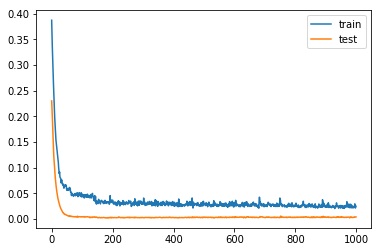

In [89]:
# fit network
history = model.fit(train_X, train_y, epochs = epoch, batch_size = batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# model.save('LSTM_12_month_42371381180000_v1.h5')
# del model

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
#SAVE THE MODEL

# model.save('LSTM_12_month_42371381340000_gas_v3.h5')
model=load_model('LSTM_12_month_42371381340000_gas_v1.h5')
# weights=model.get_weights()
# print(weights)
# model.save_weights('weights_42371381340000_gas_v3.hdf5')
# model.set_weights(weights)
weights=model.load_weights('weights_42371381340000_gas_v1.hdf5')
# model.set_weights(weights)

In [19]:
#Predict the model on test
yhat = model.predict(test_X)
# print(yhat.shape)
# print(test_y.shape)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)
# print(inv_yhat.shape)
inv_yhat = inv_yhat[:,:]

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,:]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#def mean_absolute_error(y_true, y_pred):
MAE = mean_absolute_error(inv_y, inv_yhat)
print("MAE = "+str(MAE))

Test RMSE: 985.112
MAE = 666.293


In [20]:
# make a prediction on train
yhat_train = model.predict(train_X)

# invert scaling for train forecast
inv_yhat_train = scaler.inverse_transform(yhat_train)

# invert scaling for actual train
inv_y_train = scaler.inverse_transform(train_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE: %.3f' % rmse)

#def mean_absolute_error(y_true, y_pred):
MAE_train = mean_absolute_error(inv_y_train, inv_yhat_train)
print("MAE Train = "+str(MAE_train))

Train RMSE: 8717.234
MAE Train = 4937.07


In [21]:
# Calculate Mape
# Note LSTM always gives 1 step shifted reponse

#test Mape
Mape_test1=[]
for i in range(n_seq-1):
    mape1=(np.abs(inv_y[:,i]-inv_yhat[:,i+1])/(inv_y[:,i]+1))
    Mape_test1.append(mape1)
#print(Mape_test1)
Mape_test=np.mean(Mape_test1)

#Mape_test=np.mean(np.abs(inv_y[i]-inv_yhat[i+1])/(inv_y[i]+1))
#Mape_train=np.mean(np.abs(inv_y_train[i]-inv_yhat_train[i+1])/(inv_y_train[i]+1))
Mape_train=np.mean(np.abs(inv_y_train-inv_yhat_train)/(inv_y_train+1))

print("MAPE Train = "+str(Mape_train))
print("MAPE Test = "+str(Mape_test))

MAPE Train = 223.239
MAPE Test = 0.138419


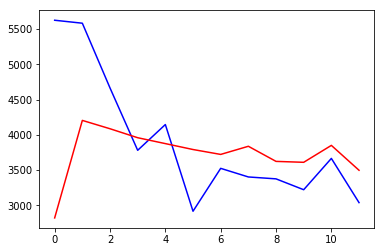

In [22]:
#red-predicted production
#blue-actual production
df1=pd.DataFrame(inv_y)
df2=pd.DataFrame(inv_yhat)
value1=df1.values
value2=df2.values
value1=value1.reshape(n_seq,1)
value2=value2.reshape(n_seq,1)
plt.figure()
plt.plot(value1,'b')
plt.plot(value2,'r')
plt.show()

In [23]:
# df1=pd.DataFrame(inv_y_train[0,:])
# df2=pd.DataFrame(inv_yhat_train[0,:])
# print(inv_y_train.shape)
# value1=df1.values
# value2=df2.values
# value1=value1.reshape(n_seq,1)
# value2=value2.reshape(n_seq,1)
# plt.figure()
# plt.plot(value1,'b')
# plt.plot(value2,'r')
# plt.show()

# df1=pd.DataFrame(inv_y_train[20,:])
# df2=pd.DataFrame(inv_yhat_train[20,:])
# print(inv_y_train.shape)
# value1=df1.values
# value2=df2.values
# value1=value1.reshape(n_seq,1)
# value2=value2.reshape(n_seq,1)
# plt.figure()
# plt.plot(value1,'b')
# plt.plot(value2,'r')
# plt.show()

# df1=pd.DataFrame(inv_y_train[40,:])
# df2=pd.DataFrame(inv_yhat_train[40,:])
# print(inv_y_train.shape)
# value1=df1.values
# value2=df2.values
# value1=value1.reshape(n_seq,1)
# value2=value2.reshape(n_seq,1)
# plt.figure()
# plt.plot(value1,'b')
# plt.plot(value2,'r')
# plt.show()

In [24]:
for i in range(len(inv_y)):
    for j in range(len(inv_y[i])):
        print(str(inv_y[i][j])+", "+str(inv_yhat[i][j]))

5624.0, 2821.24
5582.0, 4203.8
4664.0, 4085.51
3780.0, 3958.37
4145.0, 3874.84
2916.0, 3791.03
3524.0, 3721.53
3402.0, 3837.01
3375.0, 3622.75
3221.0, 3609.74
3665.0, 3849.7
3038.0, 3496.78


In [25]:
# get test results in CSV
df1=pd.DataFrame(inv_y[:,:-1])
df1=pd.DataFrame.transpose(df1)
df2=pd.DataFrame(inv_yhat[:,1:])
df2=pd.DataFrame.transpose(df2)
df3=pd.DataFrame(np.array(master_data2.iloc[-n_seq:-1,:]))
df3.columns=['YearMonth','Gas']
df4=pd.concat([df3,df1,df2],axis=1)
df4.columns=['YearMonth','Gas','Gas_Actual','Gas_Predicted']
print(df4)

    YearMonth     Gas   Gas_Actual  Gas_Predicted
0    201609.0  5624.0  5624.000000    4203.801758
1    201610.0  5582.0  5582.000000    4085.512695
2    201611.0  4664.0  4664.000000    3958.371582
3    201612.0  3780.0  3780.000244    3874.843018
4    201701.0  4145.0  4145.000000    3791.029297
5    201702.0  2916.0  2916.000000    3721.532227
6    201703.0  3524.0  3524.000244    3837.005371
7    201704.0  3402.0  3402.000000    3622.749512
8    201705.0  3375.0  3374.999756    3609.738037
9    201706.0  3221.0  3221.000000    3849.700928
10   201707.0  3665.0  3665.000000    3496.781738


In [26]:
df4.to_csv('/home/affine/Downloads/Deep_Learning/demo/demo/TGS/Models/Outputs/Gas_API_42371381340000_prediction_v1.csv')

In [27]:
df1=pd.DataFrame(inv_y_train)
df11=df1.iloc[:,0]

df2=pd.DataFrame(inv_yhat_train)
df12=df2.iloc[:,0]

df3=pd.DataFrame(np.array(master_data2.iloc[12:-n_seq,:]))
print(df3.shape)
df3.columns=['YearMonth','Gas']

df_train=pd.concat([df3,df11,df12], axis=1)
df_train1=pd.DataFrame(np.array(df_train))
df_train1.columns=['YearMonth','Gas','Gas_Actual','Gas_Predicted']
df_train1

(88, 2)


,YearMonth,Gas,Gas_Actual,Gas_Predicted
0,200905.0,155376.0,155376.000000,137686.968750
1,200906.0,132274.0,132274.000000,161368.781250
2,200907.0,122284.0,122284.000000,161256.171875
3,200908.0,165174.0,165174.000000,154019.406250
4,200909.0,180333.0,180333.000000,146153.875000
5,200910.0,179582.0,179582.000000,140527.859375
6,200911.0,172514.0,172514.000000,136577.687500
7,200912.0,161323.0,161323.000000,130333.007812
8,201001.0,147328.0,147328.000000,124468.625000
9,201002.0,130305.0,130305.000000,122541.625000


In [28]:
df_train1.to_csv('/home/affine/Downloads/Deep_Learning/demo/demo/TGS/Models/Outputs/Gas_API_42371381340000_train_prediction_v1.csv')